# Gradient estimate

## 0. Initialize

In [1]:
#mathematics
using LinearAlgebra
using ForwardDiff
using SpecialFunctions

#statistics
using Statistics
using Random
using Distributions

#visualize
using Plots
pyplot()

#macros
using ProgressMeter
using UnPack

## 1. Define functions

In [2]:
#plot the data and return the figure
function plot_data(X, Y)
    _,N = size(X)
    fig = plot(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, title="data", legend=false)
    for k in 1:N
        if Y[k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

#initialize the parameter
function init_params(st)
    @unpack  Dx, Dy, D₀ = st
    W₂ = rand(D₀, Dx)
    W₃ = rand(Dy, D₀)
    b₂ = zeros(D₀)
    b₃ = zeros(Dy)
    return W₂, W₃, b₂, b₃
end

#stick the weights and biases to a large matrix
function stick_params(W₂, W₃, b₂, b₃, Dx)
    tmp1 = vcat(b₂', W₂')
    tmp2 = hcat(tmp1, zeros(Dx+1))
    tmp3 = hcat(W₃, b₃)
    return vcat(tmp2, tmp3)
end

#devide the paramters vector to weights and biases
function reshape_params(wvec, st)
    @unpack  Dx, Dy, D₀ = st
    W = reshape(wvec, (Dx+Dy+1, D₀+1))
    W₂ = view(W, 2:Dx+1, 1:D₀)'
    W₃ = view(W, Dx+2:Dx+Dy+1, 1:D₀)
    b₂ = view(W, 1, 1:D₀)
    b₃ = view(W, Dx+2:Dx+Dy+1, D₀+1)
    return W₂, W₃, b₂, b₃
end 

#sigmoid function
σ(ξ) = 1/(1+exp(-ξ))

#Neural Network
function nn(x, wvec, st)
    W₂, W₃, b₂, b₃ = reshape_params(wvec, st)
    return σ.(W₃*σ.(W₂*x+b₂) + b₃)
end

#log pdf of prior, model, posterior, joint
logpprior(wvec, λ, dw) = logpdf(MvNormal(zeros(dw),1/sqrt(λ)), wvec)
logpmodel(y, x, wvec, st) = logpdf(Bernoulli(nn(x,wvec,st)[1]), y)
loglik(X, Y, N, wvec, st) = sum([logpmodel(Y[n], X[:,n], wvec, st) for n in 1:N])
logpjoint(X, Y, N, wvec, λw, dw, st) = loglik(X, Y, N, wvec, st) + logpprior(wvec, λw, dw) 

logpjoint (generic function with 1 method)

## 2. Create data and define a model

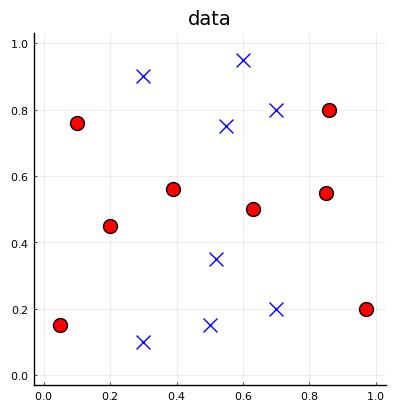

In [3]:
#create the data
N = 16
X = [
    0.3 0.52 0.3 0.50 0.60 0.7 0.70 0.55  0.85 0.10 0.05 0.20 0.39 0.63 0.86 0.97;
    0.1 0.35 0.9 0.15 0.95 0.2 0.80 0.75  0.55 0.76 0.15 0.45 0.56 0.50 0.80 0.20;
]
Y = vcat(zeros(div(N,2)), ones(div(N,2)))
data = (X=X,Y=Y,N=N)

#size
Dx,N = size(X)
Dy = 1
D₀ = 5
st = (Dx=Dx, Dy=Dy, D₀=D₀)

#initialize NN
Random.seed!(42)
W₂, W₃, b₂, b₃ = init_params(st)
Ws = stick_params(W₂, W₃, b₂, b₃, Dx)
wvec₀ = Ws[:]
dw = length(wvec₀)

#model params
λw = 1e-3
model_params = (λw=λw, dw=dw, st=st)

#plot the data
fig1 = plot_data(X, Y)
savefig(fig1, "figs-GE/fig1.png")

## 3. Define functions for gradient estimation

In [4]:
#variational approximation
varr(θvec, dw) = MvNormal(θvec[1:dw], exp.(θvec[dw+1:end]))
logvarrθw(wvec, θvec, dw) = logpdf(varr(θvec, dw), wvec)

#entropy
entropy(θvec, dw) = sum(θvec[dw+1:end]) + dw*(1+log(2*π))/2

#statistics(mean and std) for the simulation
function statistics_sims(∇Elogjoint_samps)
    d1, _, d3 = size(∇Elogjoint_samps)
    means = zeros(d1,d3)
    stds = zeros(d1,d3)
    for k in 1:d3
        for i in 1:d1
            means[i,k] = mean(∇Elogjoint_samps[i,:,k])
            stds[i,k] = std(∇Elogjoint_samps[i,:,k])
        end
    end
    return means, stds
end

""" score function estimation"""
#variational sample
variational_sample(θvec, dw, S) = rand(varr(θvec, dw), S)

#gradient of logr(w)
∇θlogvarrθw(wvec, θvec, dw) = ForwardDiff.gradient(vec->logvarrθw(wvec, vec, dw), θvec)

#Elogpjoint_samp
function ∇Elogjoint_samp_score(θvec, X, Y, N, λw, dw, st, S)
    samps = zeros(2*dw,S)
    wsamps = variational_sample(θvec, dw, S)
    for s in 1:S
        samps[:,s] = logpjoint(X, Y, N, wsamps[:,s], λw, dw, st) * ∇θlogvarrθw(wsamps[:,s], θvec, dw)
    end
    return mean(samps, dims=2)
end

#gradient of ELBO
∇θL_score(θvec,X,Y,N,λw,dw,st,S) = (
    ∇Elogjoint_samp_score(θvec,X,Y,N,λw,dw,st,S)+ForwardDiff.gradient(vec->entropy(vec,dw),θvec)
)

#variational inference using score function estimation
function myVI_score(data, model_params, α, n_train, S)
    @unpack X,Y,N = data
    @unpack λw, dw, st = model_params
    θvec = vcat(zeros(dw), ones(dw))
    θvecs = θvec * ones(n_train)'
    
    #AdaGrad
    δ = 1e-7; gθvec = zeros(2*dw); gnorm = δ * ones(2*dw)
    @showprogress for k in 2:n_train
        idx = rand(1:N)
        gθvec = ∇θL_score(θvec,X,Y,N,λw,dw,st,S)
        gnorm = gnorm + gθvec .* gθvec
        θvec += α * gθvec ./ sqrt.(gnorm)
        θvecs[:,k] = θvec
    end
    return θvecs
end

#simulate score function estimate for many times
function simlate_score(data, model_params, θvecs, n_train, n_samps, S)
    @unpack X,Y,N = data
    @unpack λw, dw, st = model_params
    ∇Elogjoint_samps = zeros(2*dw,n_samps,n_train)
    @showprogress for k in 1:n_train
        for n in 1:n_samps
            ∇Elogjoint_samps[:,n,k] = ∇Elogjoint_samp_score(θvecs[:,k], X, Y, N, λw, dw, st, S)
        end
    end
    return ∇Elogjoint_samps
end

"""reparamterization trick"""
#reparamterization
g(θvec, εvec, dw) = θvec[1:dw] + exp.(θvec[dw+1:end]).* εvec
∇θlogpmodel(X,Y,N,θvec,εsamp,dw,λw,st) =(
    ForwardDiff.gradient(vec->logpjoint(X,Y,N,g(vec,εsamp,dw),λw,dw,st),θvec)
) 

#Elogpjoint_samp
function ∇Elogjoint_samp_RP(θvec, X, Y, N, λw, dw, st, S)
    samps = zeros(2*dw,S)
    εsamps = rand(MvNormal(zeros(dw), ones(dw)), S)
    for s in 1:S
        samps[:,s] = ∇θlogpmodel(X,Y,N,θvec,εsamps[:,s],dw,λw,st)
    end
    return mean(samps, dims=2)
end

#gradient of ELBO
∇θL_RP(θvec,X,Y,N,λw,dw,st,S) = (
    ∇Elogjoint_samp_RP(θvec,X,Y,N,λw,dw,st,S)+ForwardDiff.gradient(vec->entropy(vec,dw),θvec)
)

#variational inference using reparameterization trick
function myVI_RP(data, model_params, α, n_train, S)
    @unpack X,Y,N = data
    @unpack λw, dw, st = model_params
    θvec = vcat(zeros(dw), ones(dw))
    θvecs = θvec * ones(n_train)'
    
    #AdaGrad
    δ = 1e-7; gθvec = zeros(2*dw); gnorm = δ * ones(2*dw)
    @showprogress for k in 2:n_train
        idx = rand(1:N)
        gθvec = ∇θL_RP(θvec,X,Y,N,λw,dw,st,S)
        gnorm = gnorm + gθvec .* gθvec
        θvec += α * gθvec ./ sqrt.(gnorm)
        θvecs[:,k] = θvec
    end
    return θvecs
end

#simulate reparameterization trick for many times
function simlate_RP(data, model_params, θvecs, n_train, n_samps, S)
    @unpack X,Y,N = data
    @unpack λw, dw, st = model_params
    ∇Elogjoint_samps = zeros(2*dw,n_samps,n_train)
    @showprogress for k in 1:n_train
        for n in 1:n_samps
            ∇Elogjoint_samps[:,n,k] = ∇Elogjoint_samp_RP(θvecs[:,k], X, Y, N, λw, dw, st, S)
        end
    end
    return ∇Elogjoint_samps
end

simlate_RP (generic function with 1 method)

## 4. Compare score function method and reparameterization trick

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


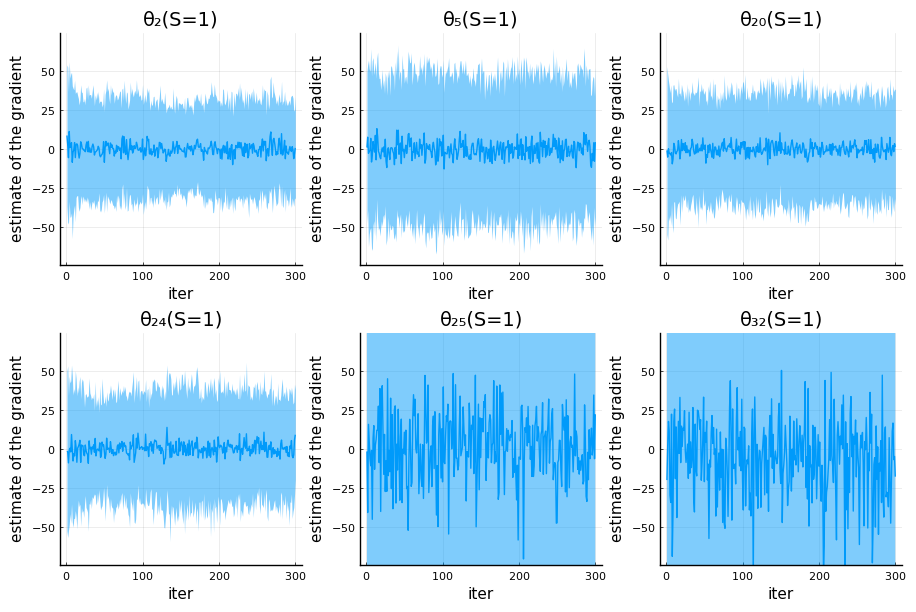

  1.667682 seconds (6.06 M allocations: 2.546 GiB, 35.89% gc time, 0.24% compilation time)


In [7]:
#set the random seed
Random.seed!(42)

#variational inference
α = 0.1
S = 1
n_train = 300
θvecs_score = myVI_score(data, model_params, α, n_train, S)

#simulate score function estimate 
n_samps = 100
@time ∇Elogjoint_samps = simlate_score(data, model_params, θvecs_score, n_train, n_samps, S)

#summarize the simulation
means, stds = statistics_sims(∇Elogjoint_samps)

#visualize
p1 = plot(means[2,:], title="θ₂(S=$(S))", ribbon=stds[2,:])
p2 = plot(means[5,:], title="θ₅(S=$(S))", ribbon=stds[5,:])
p3 = plot(means[20,:], title="θ₂₀(S=$(S))", ribbon=stds[20,:])
p4 = plot(means[24,:], title="θ₂₄(S=$(S))", ribbon=stds[24,:])
p5 = plot(means[25,:], title="θ₂₅(S=$(S))", ribbon=stds[25,:])
p6 = plot(means[32,:], title="θ₃₂(S=$(S))", ribbon=stds[32,:])
fig2 = plot([p1, p2, p3, p4, p5, p6]..., ylim=[-70,70])
plot!(xlabel="iter", ylabel="estimate of the gradient", size=(900, 600), legend=false)
savefig(fig2, "figs-GE/fig2.png")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


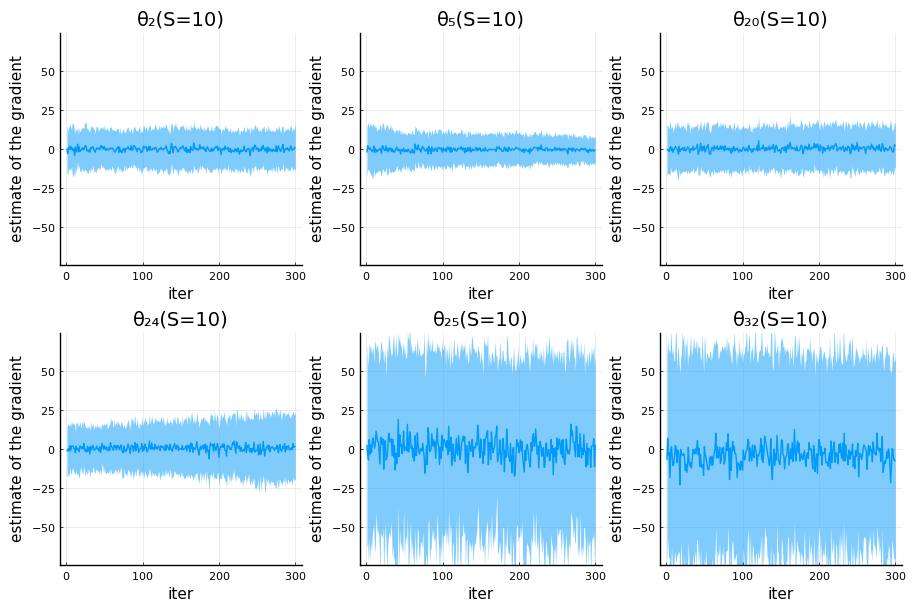

 13.489690 seconds (55.22 M allocations: 24.479 GiB, 38.90% gc time)


In [8]:
#set the random seed
Random.seed!(42)

#variational inference
α = 0.1
S = 10
n_train = 300
θvecs_score = myVI_score(data, model_params, α, n_train, S)

#simulate score function estimate 
n_samps = 100
@time ∇Elogjoint_samps = simlate_score(data, model_params, θvecs_score, n_train, n_samps, S)

#summarize the simulation
means, stds = statistics_sims(∇Elogjoint_samps)

#visualize
p1 = plot(means[2,:], title="θ₂(S=$(S))", ribbon=stds[2,:])
p2 = plot(means[5,:], title="θ₅(S=$(S))", ribbon=stds[5,:])
p3 = plot(means[20,:], title="θ₂₀(S=$(S))", ribbon=stds[20,:])
p4 = plot(means[24,:], title="θ₂₄(S=$(S))", ribbon=stds[24,:])
p5 = plot(means[25,:], title="θ₂₅(S=$(S))", ribbon=stds[25,:])
p6 = plot(means[32,:], title="θ₃₂(S=$(S))", ribbon=stds[32,:])
fig3 = plot([p1, p2, p3, p4, p5, p6]..., ylim=[-70,70])
plot!(xlabel="iter", ylabel="estimate of the gradient", size=(900, 600), legend=false)
savefig(fig3, "figs-GE/fig3.png")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


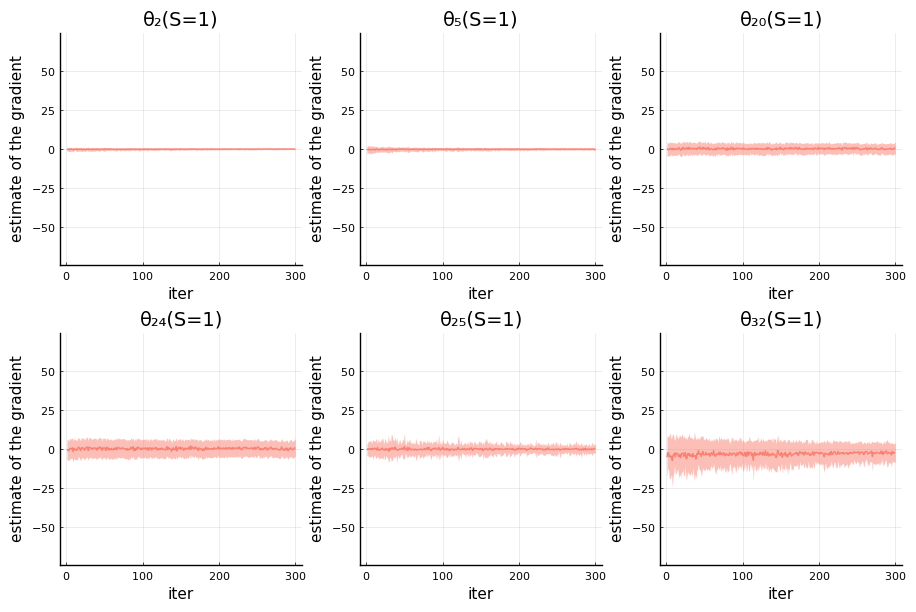

  3.526453 seconds (18.94 M allocations: 6.772 GiB, 34.64% gc time)


In [10]:
#set the random seed
Random.seed!(42)

#variational inference
α = 0.1
S = 1
n_train = 300
θvecs_RP = myVI_RP(data, model_params, α, n_train, S)

#simulate score function estimate 
n_samps = 100
@time ∇Elogjoint_samps = simlate_RP(data, model_params, θvecs_RP, n_train, n_samps, S)

#summarize the simulation
means, stds = statistics_sims(∇Elogjoint_samps)

#visualize
p1 = plot(means[2,:], title="θ₂(S=$(S))", ribbon=stds[2,:], color="salmon")
p2 = plot(means[5,:], title="θ₅(S=$(S))", ribbon=stds[5,:], color="salmon")
p3 = plot(means[20,:], title="θ₂₀(S=$(S))", ribbon=stds[20,:], color="salmon")
p4 = plot(means[24,:], title="θ₂₄(S=$(S))", ribbon=stds[24,:], color="salmon")
p5 = plot(means[25,:], title="θ₂₅(S=$(S))", ribbon=stds[25,:], color="salmon")
p6 = plot(means[32,:], title="θ₃₂(S=$(S))", ribbon=stds[32,:], color="salmon")
fig4 = plot([p1, p2, p3, p4, p5, p6]..., ylim=[-70,70])
plot!(xlabel="iter", ylabel="estimate of the gradient", size=(900, 600), legend=false)
savefig(fig4, "figs-GE/fig4.png")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


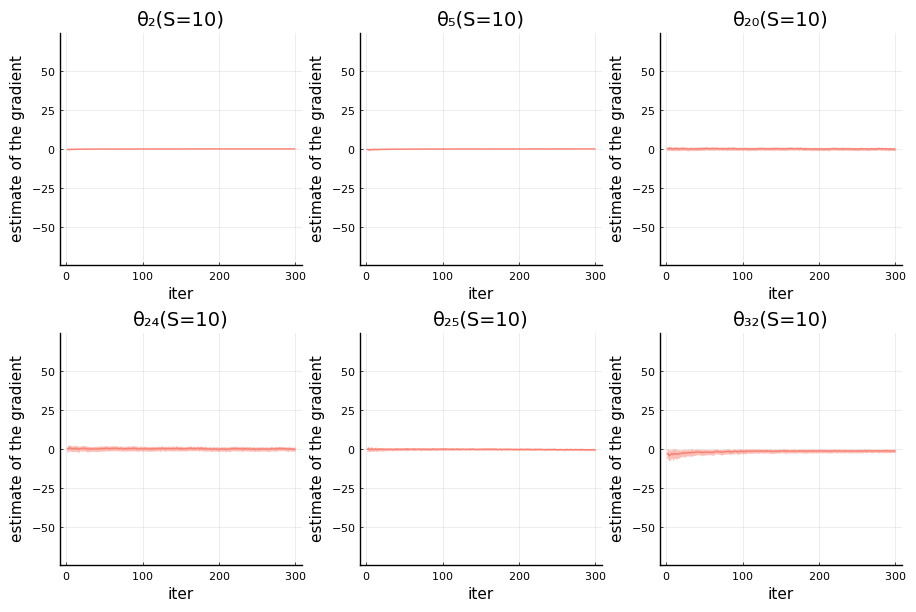

 32.608437 seconds (184.21 M allocations: 66.807 GiB, 36.29% gc time)


In [11]:
#set the random seed
Random.seed!(42)

#variational inference
α = 0.1
S = 10
n_train = 300
θvecs_RP = myVI_RP(data, model_params, α, n_train, S)

#simulate score function estimate 
n_samps = 100
@time ∇Elogjoint_samps = simlate_RP(data, model_params, θvecs_RP, n_train, n_samps, S)

#summarize the simulation
means, stds = statistics_sims(∇Elogjoint_samps)

#visualize
p1 = plot(means[2,:], title="θ₂(S=$(S))", ribbon=stds[2,:], color="salmon")
p2 = plot(means[5,:], title="θ₅(S=$(S))", ribbon=stds[5,:], color="salmon")
p3 = plot(means[20,:], title="θ₂₀(S=$(S))", ribbon=stds[20,:], color="salmon")
p4 = plot(means[24,:], title="θ₂₄(S=$(S))", ribbon=stds[24,:], color="salmon")
p5 = plot(means[25,:], title="θ₂₅(S=$(S))", ribbon=stds[25,:], color="salmon")
p6 = plot(means[32,:], title="θ₃₂(S=$(S))", ribbon=stds[32,:], color="salmon")
fig5 = plot([p1, p2, p3, p4, p5, p6]..., ylim=[-70,70])
plot!(xlabel="iter", ylabel="estimate of the gradient", size=(900, 600), legend=false)
savefig(fig5, "figs-GE/fig5.png")

## 5. Estimation precision with different sample size

In [13]:
#simulate score function method
function simulate_score(data, model_params, θvec, n_samps, Smax)
    @unpack X,Y,N = data
    @unpack λw, dw, st = model_params
    ∇Elogjoint_samps = zeros(2*dw,n_samps,Smax)
    @showprogress for sample_size in 1:Smax
        for n in 1:n_samps
            ∇Elogjoint_samps[:,n,sample_size] = ∇Elogjoint_samp_score(θvec, X, Y, N, λw, dw, st, sample_size)
        end
    end
    return ∇Elogjoint_samps
end

#simulate reparameterization trick 
function simulate_RP(data, model_params, θvec, n_samps, Smax)
    @unpack X,Y,N = data
    @unpack λw, dw, st = model_params
    ∇Elogjoint_samps = zeros(2*dw,n_samps,Smax)
    @showprogress for sample_size in 1:Smax
        for n in 1:n_samps
            ∇Elogjoint_samps[:,n,sample_size] = ∇Elogjoint_samp_RP(θvec, X, Y, N, λw, dw, st, sample_size)
        end
    end
    return ∇Elogjoint_samps
end

simulate_RP (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


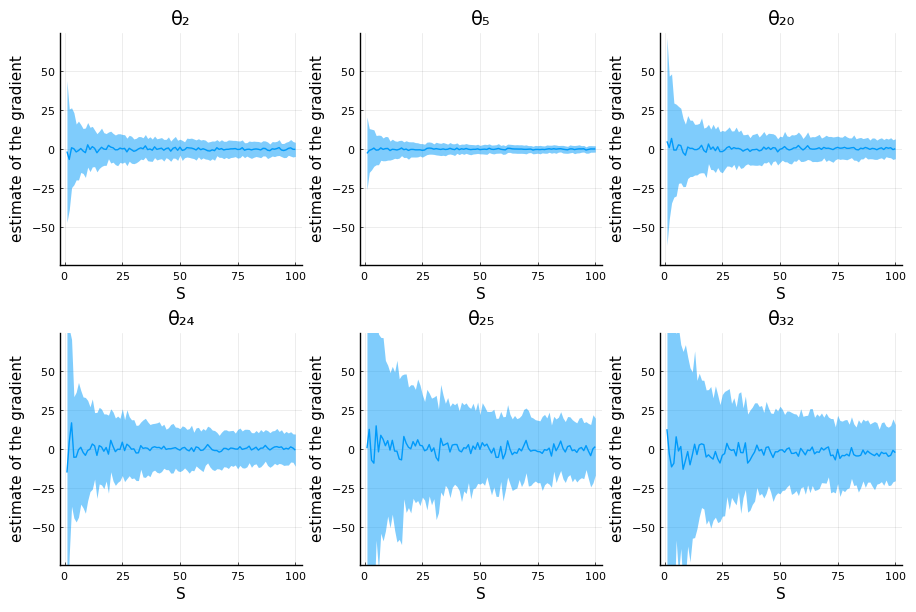

 22.153470 seconds (92.12 M allocations: 41.052 GiB, 37.80% gc time)


In [15]:
#set the random seed
Random.seed!(42)

#variational inference
α = 0.1
S = 100
n_train = 300
θvecs_score = myVI_score(data, model_params, α, n_train, S)

#simulate score function estimate 
n_samps = 100
Smax = 100
@time ∇Elogjoint_samps = simulate_score(data, model_params, θvecs_score[:,end], n_samps, Smax)

#summarize the simulation
means, stds = statistics_sims(∇Elogjoint_samps)

#visualize
p1 = plot(means[2,:], title="θ₂", ribbon=stds[2,:])
p2 = plot(means[5,:], title="θ₅", ribbon=stds[5,:])
p3 = plot(means[20,:], title="θ₂₀", ribbon=stds[20,:])
p4 = plot(means[24,:], title="θ₂₄", ribbon=stds[24,:])
p5 = plot(means[25,:], title="θ₂₅", ribbon=stds[25,:])
p6 = plot(means[32,:], title="θ₃₂", ribbon=stds[32,:])
fig6 = plot([p1, p2, p3, p4, p5, p6]..., ylim=[-70,70])
plot!(xlabel="S", ylabel="estimate of the gradient", size=(900, 600), legend=false)
savefig(fig6, "figs-GE/fig6.png")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


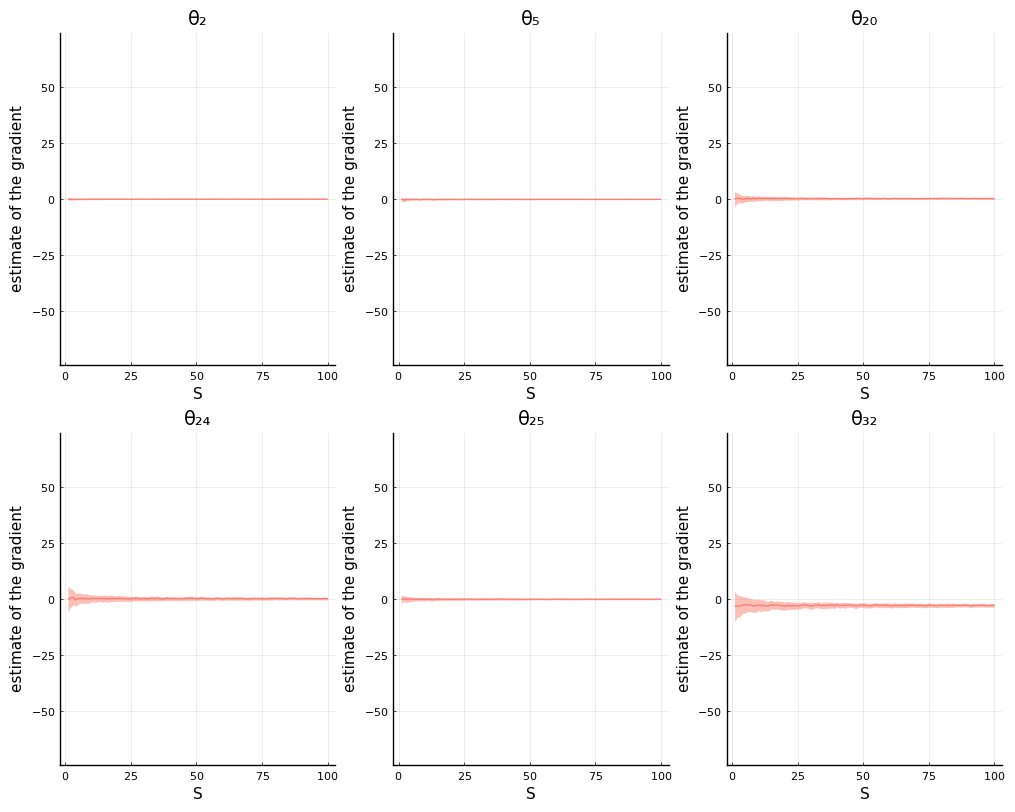

 54.840416 seconds (309.31 M allocations: 112.315 GiB, 35.25% gc time, 0.05% compilation time)


In [16]:
#set the random seed
Random.seed!(42)

#variational inference
α = 0.1
S = 100
n_train = 300
θvecs_RP = myVI_RP(data, model_params, α, n_train, S)

#simulate score function estimate 
n_samps = 100
Smax = 100
@time ∇Elogjoint_samps = simulate_RP(data, model_params, θvecs_score[:,end], n_samps, Smax)

#summarize the simulation
means, stds = statistics_sims(∇Elogjoint_samps)

#visualize
p1 = plot(means[2,:], title="θ₂", ribbon=stds[2,:], color="salmon")
p2 = plot(means[5,:], title="θ₅", ribbon=stds[5,:], color="salmon")
p3 = plot(means[20,:], title="θ₂₀", ribbon=stds[20,:], color="salmon")
p4 = plot(means[24,:], title="θ₂₄", ribbon=stds[24,:], color="salmon")
p5 = plot(means[25,:], title="θ₂₅", ribbon=stds[25,:], color="salmon")
p6 = plot(means[32,:], title="θ₃₂", ribbon=stds[32,:], color="salmon")
fig7 = plot([p1, p2, p3, p4, p5, p6]..., ylim=[-70,70])
plot!(xlabel="S", ylabel="estimate of the gradient", size=(1000, 800), legend=false)
savefig(fig7, "figs-GE/fig7.png")